# HERA RFI Analysis



# Load Files

In [1]:
%matplotlib inline
import sys
from pyuvdata import UVData
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import itertools
import os

# load data here.

#items = os.listdir(".")
str_dir = '/Users/josaitis/RFI_Analysis_7May/files/'
#str_dir = '/lustre/aoc/projects/hera/ajosaiti/May7_RFI/2458610/'
items = os.listdir(str_dir)

uvfiles = []
for names in items:
    if names.endswith(".HH.uvh5"):
        uvfiles.append(names)
print('Files to process, in dir '+str_dir+': '+str(uvfiles))
uvfiles = [str_dir + s  for s in uvfiles]


uvd = UVData()
uvd.read_uvh5(uvfiles, axis='blt')

Files to process, in dir /Users/josaitis/RFI_Analysis_7May/files/: ['zen.2458611.16975.HH.uvh5', 'zen.2458611.16348.HH.uvh5', 'zen.2458611.17183.HH.uvh5', 'zen.2458611.17810.HH.uvh5', 'zen.2458611.15722.HH.uvh5', 'zen.2458611.15513.HH.uvh5', 'zen.2458611.16766.HH.uvh5', 'zen.2458611.17392.HH.uvh5', 'zen.2458611.16557.HH.uvh5', 'zen.2458611.17601.HH.uvh5', 'zen.2458611.16139.HH.uvh5', 'zen.2458611.15096.HH.uvh5', 'zen.2458611.15304.HH.uvh5', 'zen.2458611.15931.HH.uvh5']


In [2]:
# your answers here (hint: look at the attributes of your uvd object)

print 'There are', len(uvd.antenna_numbers), 'antennas and they are:', uvd.antenna_numbers

print 'There are', uvd.Nbls, 'baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.'

print 'There are', uvd.Nfreqs, 'frequencies, covering a range of', \
    np.min(uvd.freq_array)/1e6, 'MHz to',np.max(uvd.freq_array)/1e6,'MHz.'

print 'The width of each frequency channel is', (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e6, 'MHz'

print 'There are', uvd.Ntimes, 'time integrations.'

print 'The LSTs are', np.unique(uvd.lst_array)*12/np.pi, 'in hours.'

There are 11 antennas and they are: [ 0  1  2 11 12 13 23 24 25 26 39]
There are 66 baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.
There are 1536 frequencies, covering a range of 46.9207763671875 MHz to 234.2987060546875 MHz.
The width of each frequency channel is 0.12199083964029948 MHz
There are 294 time integrations.
The LSTs are [8.06406368 8.06645631 8.06884894 8.07124156 8.07363419 8.07602681
 8.07841944 8.08081207 8.08320469 8.08559732 8.08798994 8.09038257
 8.0927752  8.09516782 8.09756045 8.09995306 8.10234569 8.10473832
 8.10713094 8.10952357 8.1119162  8.11430882 8.11670145 8.11909407
 8.1214867  8.12387933 8.12627195 8.12866458 8.1310572  8.13344983
 8.13584246 8.13823508 8.14062771 8.14302034 8.14541296 8.14780559
 8.15019821 8.15259084 8.15498347 8.15737609 8.15976872 8.16216135
 8.16455397 8.1669466  8.16933922 8.17173185 8.17412448 8.1765171
 8.17890973 8.18130235 8.18369498 8.18608761 8.18848023 8.19087286
 8.19326549 8.19565811 8

# B) Visualizing Data and Flags

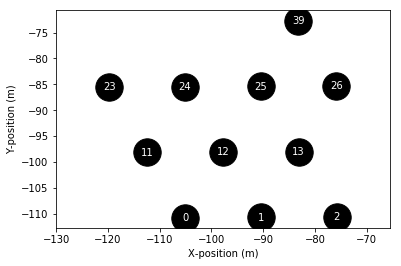

In [3]:
import matplotlib.pyplot as plt
#%matplotlib notebook

antpos, ants = uvd.get_ENU_antpos() # this returns coordinates of each antenna and a list of the antennas

plt.figure()
plt.scatter(antpos[:,0], antpos[:,1], marker='.', color='k', s=3000) # plot the antenna positions with black circles
for aa,ant in enumerate(ants): # loop over antennas
    plt.text(antpos[aa,0], antpos[aa,1], ants[aa], color='w', va='center', ha='center') # label antenna numbers
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.axis('equal');

# C) Pre-XRFI Waterfall Plots

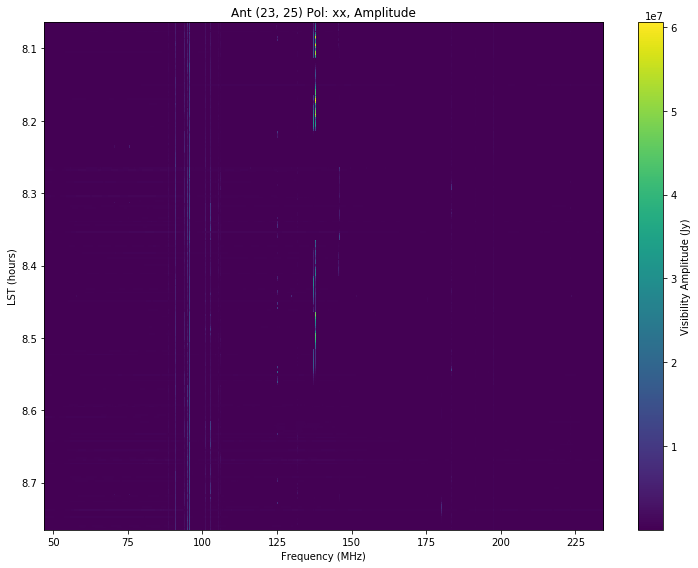

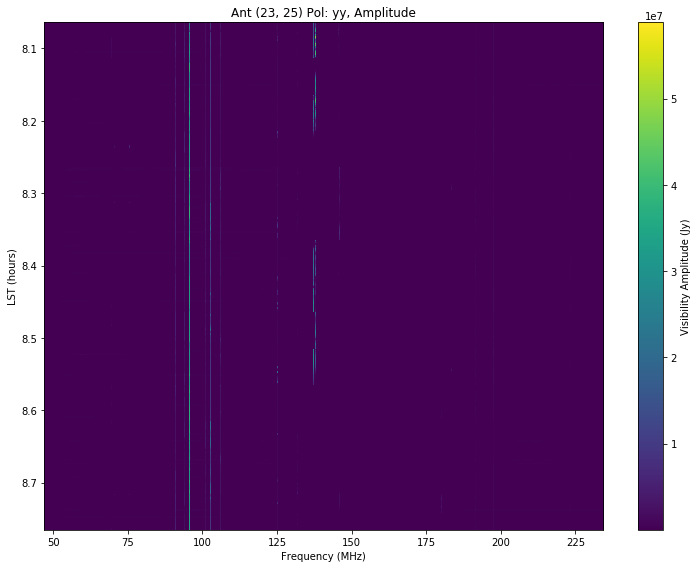

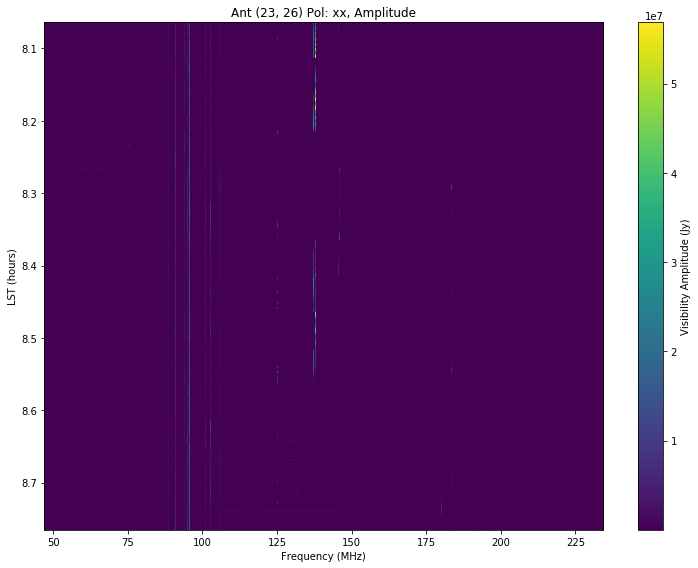

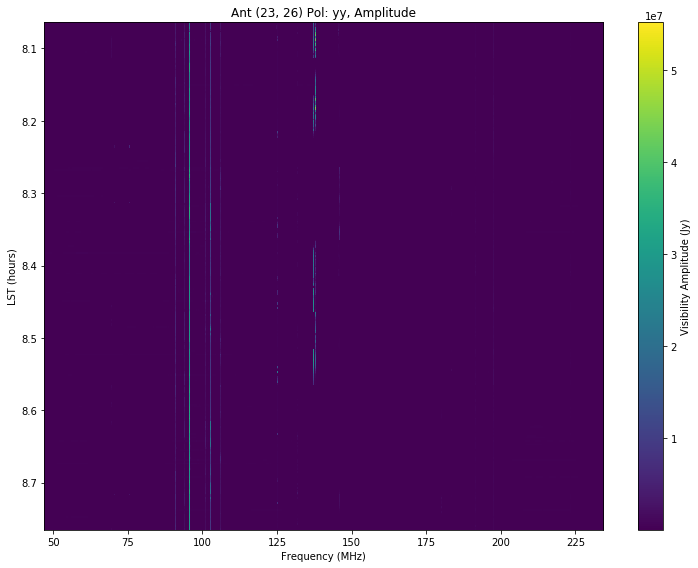

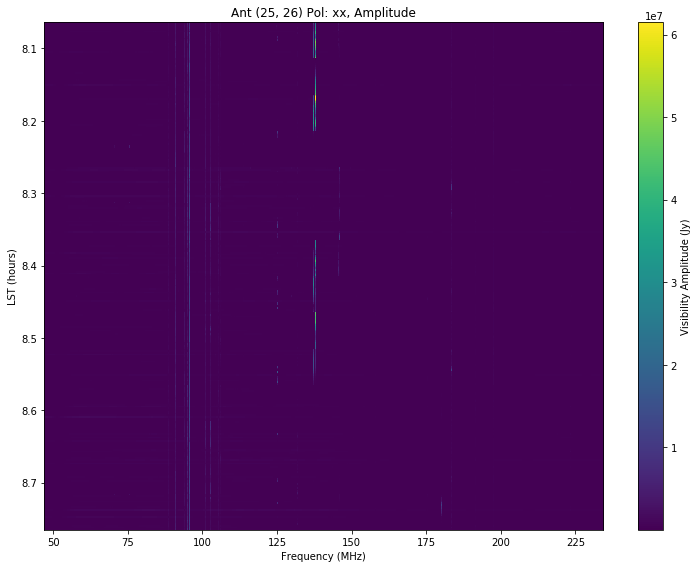

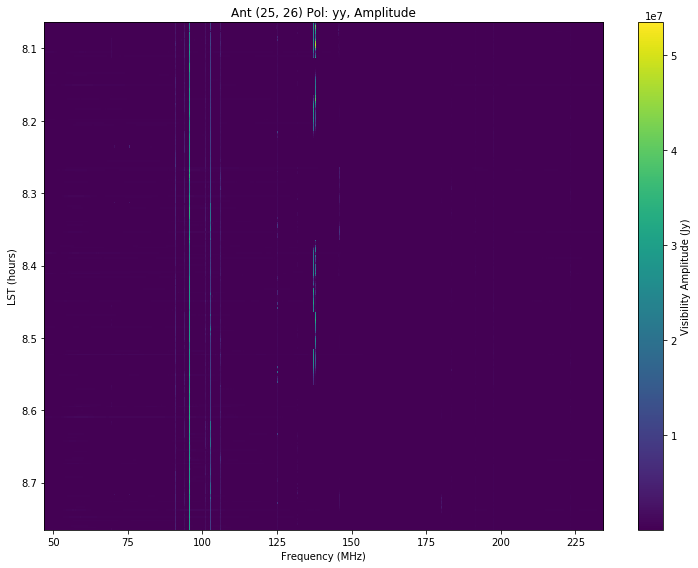

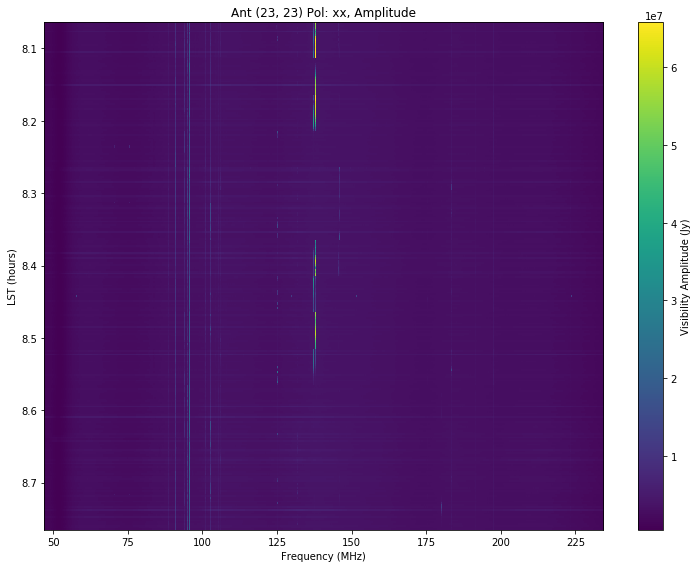

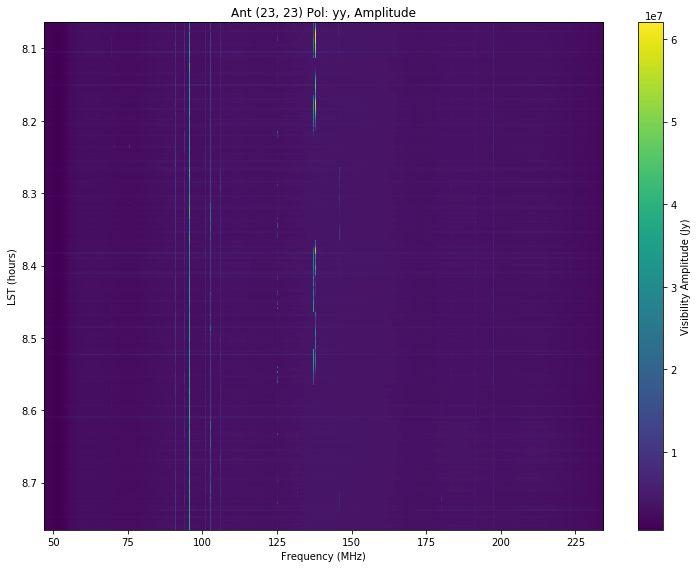

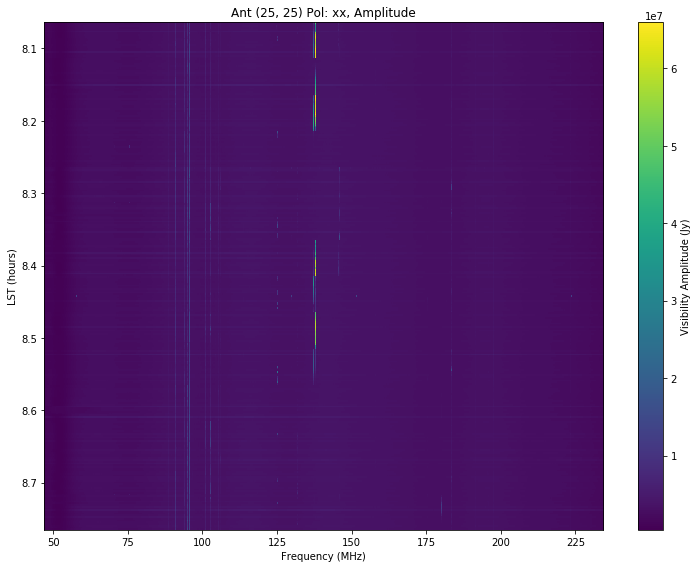

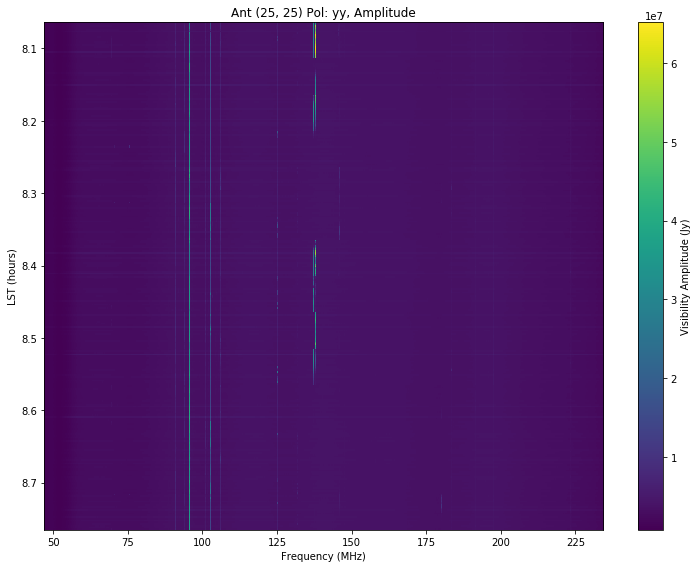

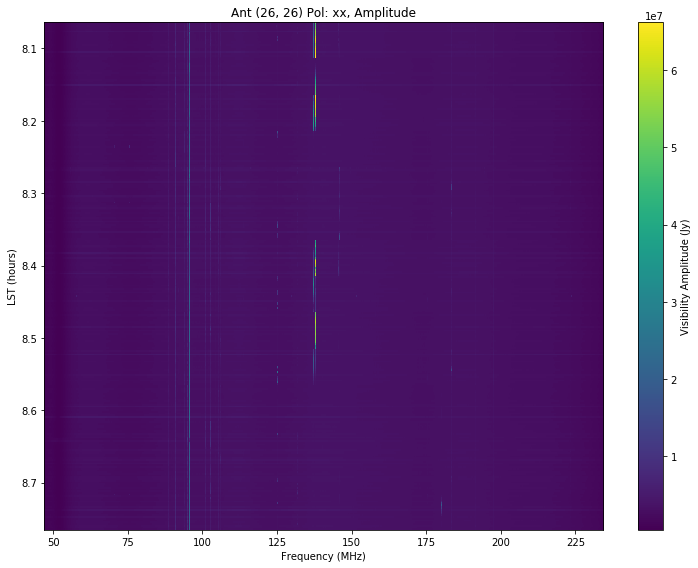

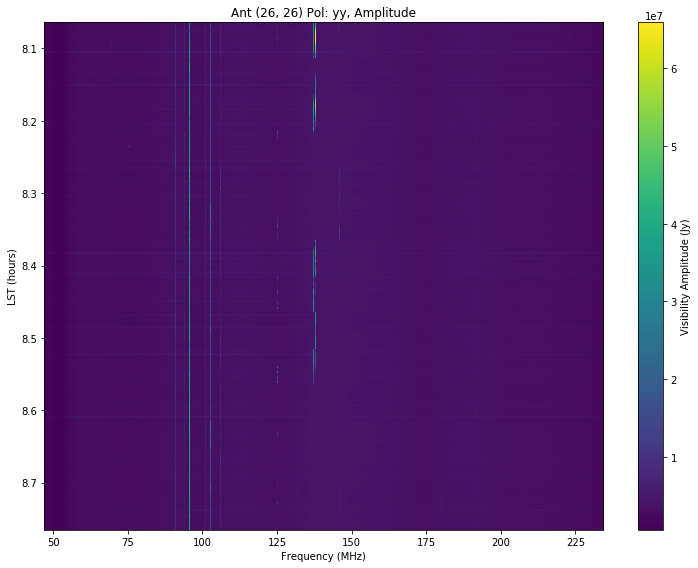

In [4]:
import matplotlib 

ants_select = np.array([23,25,26])
ant_combination = np.array( list( itertools.combinations(ants_select, 2) ) )
for ant in ants_select:
    ant_combination= np.append(ant_combination, [[ant,ant]], axis=0)
    
np.shape(ant_combination)

ii=0
while ii < np.size(ant_combination[:,0]):
    pols = np.array(['xx','yy'])
    for pol in pols:
        key=(ant_combination[ii,0],ant_combination[ii,1],str(pol))
        vis=uvd.get_data(key)
        plt.figure(figsize=(20,8))
        
        plt.subplot(121) #For amplitude
        plt.imshow(np.abs(vis), aspect='auto',extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('Ant ('+str(ant_combination[ii,0])+', '+str(ant_combination[ii,1])+') Pol: '+str(pol)+', Amplitude')

        plt.tight_layout();
    ii = ii+1


# Median and Mean Statistics, XRFI and Boxplot 

In [19]:
import xrfi_funcs
key=(26,26,'xx')
vis=uvd.get_data(key)
powers_per_time = np.abs(vis)
#calc XRFI-flagged visibility
XRFI_mask = xrfi_funcs.xrfi(powers_per_time)
powers_per_time_XRFI=np.ma.array(powers_per_time,mask=XRFI_mask)
total_power_chan_XRFI=10.0 * np.log10(np.sum(np.power(10.0, np.ma.masked_array(powers_per_time_XRFI).filled(np.ma.masked_array(powers_per_time_XRFI).mean()) / 10.0),0))

'''
x_boxplot=list(uvd.freq_array[0]/1.e6)
meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
#plt.figure(1,figsize=(25,25))
#plt.boxplot(abs(vis),widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)

#plt.title('Boxplot (Pre XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')
#plt.xticks(rotation='vertical')
#plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')
#ylim_min = 1.05*np.min(np.min(powers_per_time,axis=0))#ATJ
#ylim_max = 0.95*np.max(np.max(powers_per_time,axis=0)) #ATJ
#plt.ylim([ylim_min,ylim_max])#ATJ

plt.figure(1,figsize=(25,25))
pwr_xrfi_vec_seq = [[y for y in row if y] for row in powers_per_time_XRFI.T]
plt.figure(1,figsize=(25,25))
plt.boxplot(pwr_xrfi_vec_seq,widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)
plt.title('Boxplot (Post XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')
plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')
#plt.ylim([ylim_min, ylim_max]) 

K = 8 #the box size for taking medians in xrfi, see xrfi_funcs.xrfi()
arr2D_pow = np.tile( np.max( np.ma.masked_array(powers_per_time_XRFI).filled(np.ma.masked_array(powers_per_time_XRFI).mean() ),axis=0) , (int(2.*K +2),1))
print('For XRFI algorithm: K = '+str(K)+', shape of xrfi input (arr2D_pow): '+str(np.shape(arr2D_pow)))
xrfi_mask = xrfi_funcs.xrfi( arr2D_pow, K=K )
masked_y = np.ma.masked_array( arr2D_pow[0,:][np.where(xrfi_mask[0,:])])
print('After running XRFI on the full data set, if I run a 1D XRFI on the max vals per channel, I get '+str(np.size(np.where(xrfi_mask[0,:])))+' channels that still could be RFI'  )

'''

overflow encountered in power


"\nx_boxplot=list(uvd.freq_array[0]/1.e6)\nmeanlineprops = dict(linestyle='--', linewidth=2.5, color='green')\nmedianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')\n#plt.figure(1,figsize=(25,25))\n#plt.boxplot(abs(vis),widths=0.05,meanprops=meanlineprops,showfliers=False,positions=x_boxplot,meanline=True,whis='range',patch_artist=True,manage_xticks=False)\n\n#plt.title('Boxplot (Pre XRFI): Median (Red), Mean (Green), 25/75th Percentiles, and Max/Min.')\n#plt.xticks(rotation='vertical')\n#plt.xticks(np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,50),rotation='vertical')\n#ylim_min = 1.05*np.min(np.min(powers_per_time,axis=0))#ATJ\n#ylim_max = 0.95*np.max(np.max(powers_per_time,axis=0)) #ATJ\n#plt.ylim([ylim_min,ylim_max])#ATJ\n\nplt.figure(1,figsize=(25,25))\npwr_xrfi_vec_seq = [[y for y in row if y] for row in powers_per_time_XRFI.T]\nplt.figure(1,figsize=(25,25))\nplt.boxplot(pwr_xrfi_vec_seq,widths=0.05,meanprops=meanlineprops,showfliers=False

In [6]:
import scipy.signal;
import scipy.stats;

def running_median(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    out = np.median(x[idx],axis=1)
    zeropad=list(np.zeros(N/2)) # this aligns the array again
    out = np.array(zeropad+list(out))
    return out

def rolling_z(x, N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    out = scipy.stats.zscore(x[idx],axis=1)
    out_except_end = [row[0] for row in out] # proprietary - pick 0th element of each length N and call it the Z score there, perhaps this should be N/2
    out = np.append(out_except_end, out[-1][-(N-1):])
    return out

def find_nearest_val(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


# Neighboring channel analysis - Antenna 26, Pol XX

Post XRFI: detect low-level RFI. Try calculating ratio of median over all time (persistent RFI) and std over all time (for transient RFI) of neighboring channels. Which channels have the highest ratios? Also perform an integrated-overall-all-time, per channel comparison. 

divide by zero encountered in divide
invalid value encountered in divide


"\nplt.figure(figsize=(figx,figy))\nplt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(np.abs(ratio_mean-1.)))\nplt.title('log(Ratio of Means -1.) (Neighboring Channel)')\nplt.xticks(xticks,rotation='vertical')\n\nmedian = np.median(powers_per_time_XRFI,axis=0)\nratio_median = np.divide(median[1:], median[:-1])\nplt.figure(figsize=(figx,figy))\nplt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_median)\nplt.title('Ratio of Medians (Neighboring Channel)')\nplt.xticks(xticks,rotation='vertical')\nplt.ylim((ymin,ymax))\n\nplt.figure(figsize=(figx,figy))\nplt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(np.abs(ratio_median-1.)))\nplt.title('log(Ratio of Medians -1.) (Neighboring Channel)')\nplt.xticks(xticks,rotation='vertical')\n\n\nstd = np.std(powers_per_time_XRFI,axis=0)\nratio_std = np.divide(std[1:], std[:-1])\nplt.figure(figsize=(figx,figy))\nplt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_std)\nplt.title('Ratio of Standard Deviations (Neighboring Channel)')\nplt.

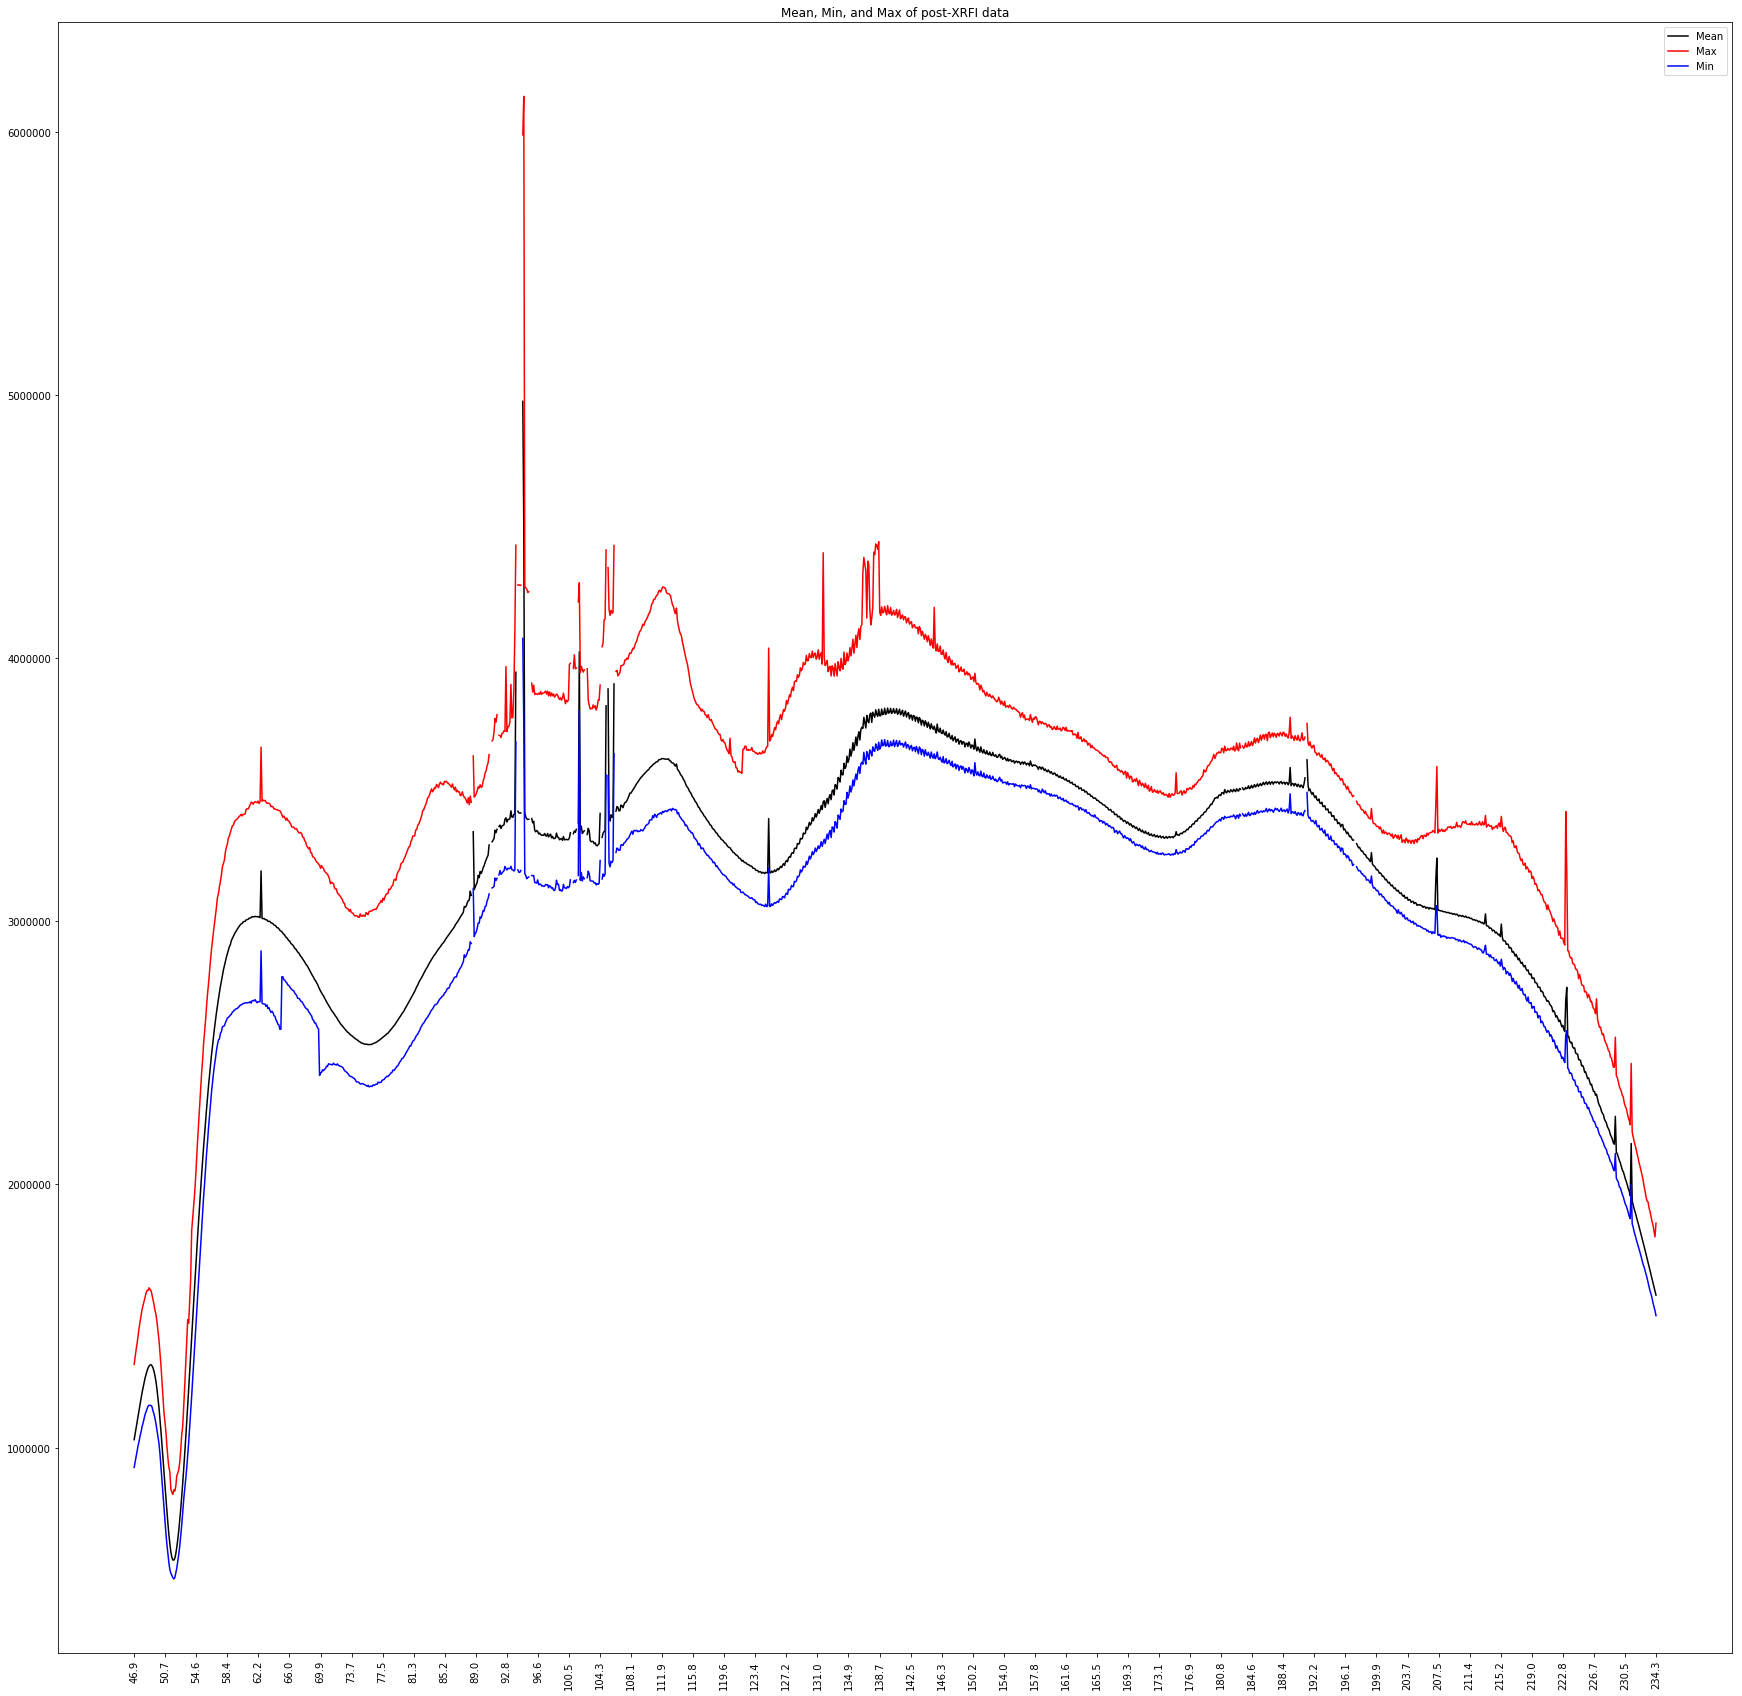

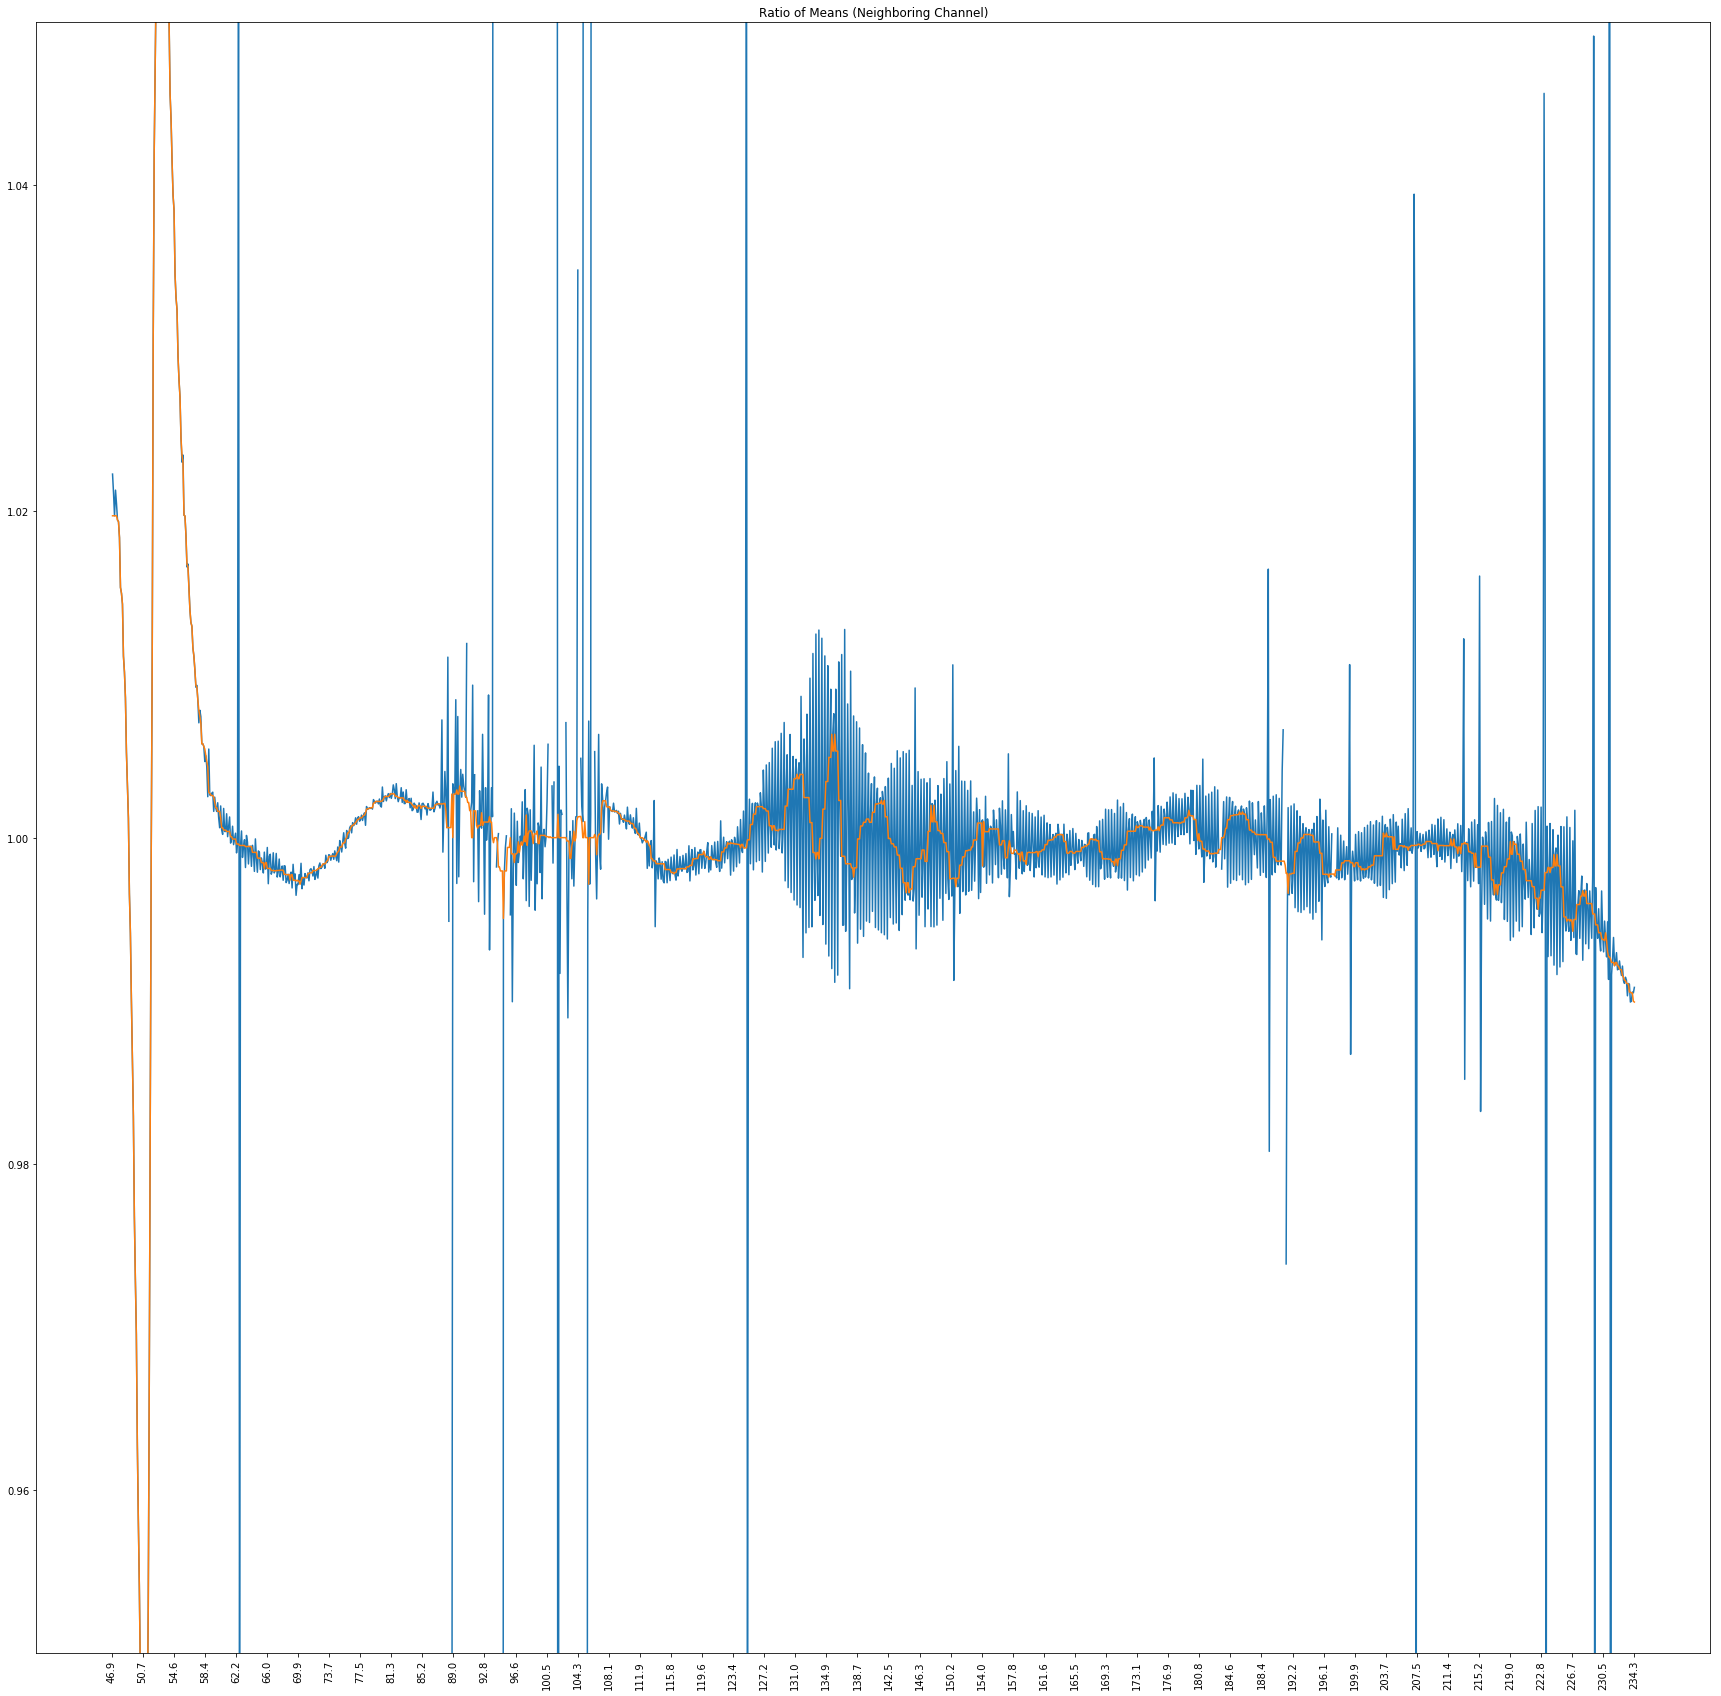

In [20]:
figx=30;figy=30; 
xticks=np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(np.array(uvd.freq_array[0]/1.e6)[1:]),50);
ymin=0.95;ymax=1.05
N_med = 9


max_preXRFI = np.max(powers_per_time,axis=0)
mean = np.mean(powers_per_time_XRFI,axis=0)
arr_max = np.max(powers_per_time_XRFI,axis=0)
arr_min = np.min(powers_per_time_XRFI,axis=0)

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6), mean,'k-',label='Mean')
#plt.plot( np.array(uvd.freq_array[0]/1.e6), max_preXRFI,'g-',label='Raw Max, before XRFI')
plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_max,'r-',label='Max')
plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_min,'b-',label='Min')
plt.title('Mean, Min, and Max of post-XRFI data')
plt.legend()
plt.xticks(xticks,rotation='vertical')

ratio_mean = np.divide(mean[1:], mean[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_mean)
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], scipy.signal.medfilt(ratio_mean, N_med) ) #[:-int(N_med-4)]
plt.title('Ratio of Means (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')
plt.ylim((ymin,ymax))

'''
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(np.abs(ratio_mean-1.)))
plt.title('log(Ratio of Means -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')

median = np.median(powers_per_time_XRFI,axis=0)
ratio_median = np.divide(median[1:], median[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_median)
plt.title('Ratio of Medians (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')
plt.ylim((ymin,ymax))

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(np.abs(ratio_median-1.)))
plt.title('log(Ratio of Medians -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')


std = np.std(powers_per_time_XRFI,axis=0)
ratio_std = np.divide(std[1:], std[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], ratio_std)
plt.title('Ratio of Standard Deviations (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')
plt.ylim((0.5,1.5))

plt.figure(figsize=(figx,figy))
plt.plot( np.array(uvd.freq_array[0]/1.e6)[1:], np.log(np.abs(ratio_std-1.)))
plt.title('log(Ratio of Standard Deviations -1.) (Neighboring Channel)')
plt.xticks(xticks,rotation='vertical')


std = np.std(powers_per_time_XRFI,axis=0)
ratio_std = np.divide(std[1:], std[:-1])
plt.figure(figsize=(figx,figy))
plt.plot( uvd.freq_array[0]/1.e6, std)
plt.title('Standard Deviation Per Channel')
plt.xticks(xticks,rotation='vertical')
'''

# Use some of the above, neighboring-channel stats to eliminate what could be RFI

chan_min = 1090, chan_max = 1336
Nmed = 7
First Nmed values of running med: [1030022.02846975 1052984.70714286 1075227.13357401 1096448.05474453
 1119811.86813187 1142733.16605166 1164994.07380074]
Last Nmed values of running med: [1672780.09259259 1657753.22058824 1641041.81617647 1624578.00367647
 1609192.19343066 1593873.64981949 1579239.75800712]


invalid value encountered in greater
invalid value encountered in greater


Text(0.5,1,'Rollng Z score, full range')

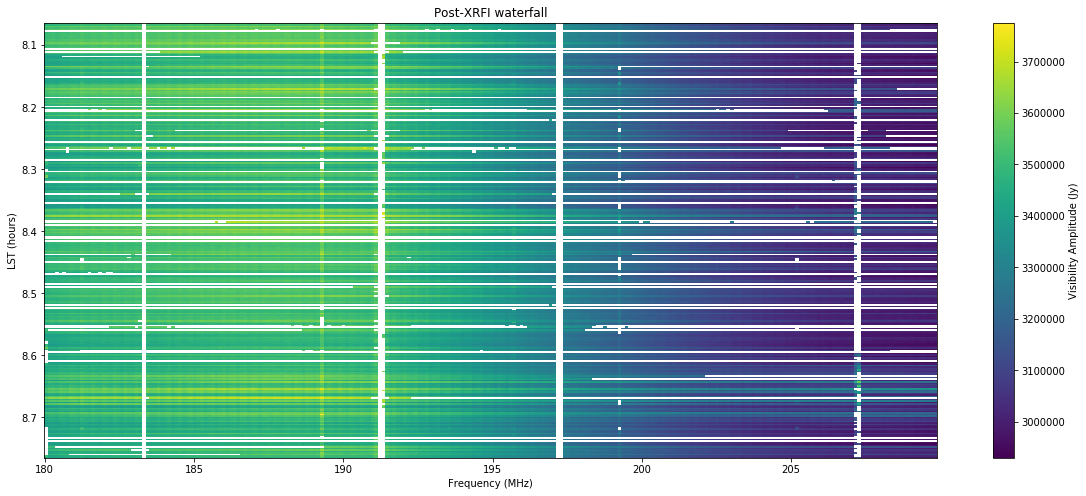

<Figure size 1440x576 with 0 Axes>

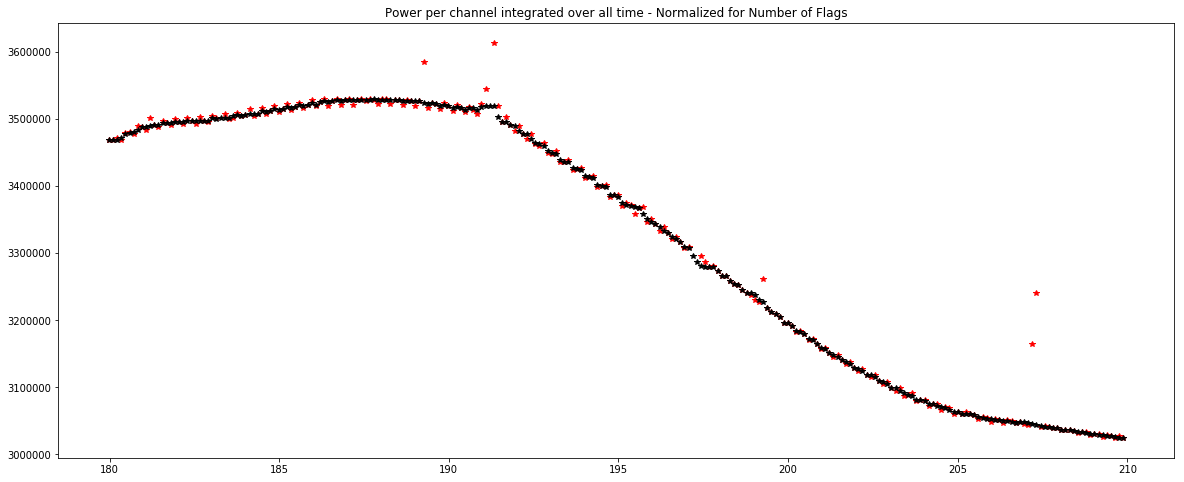

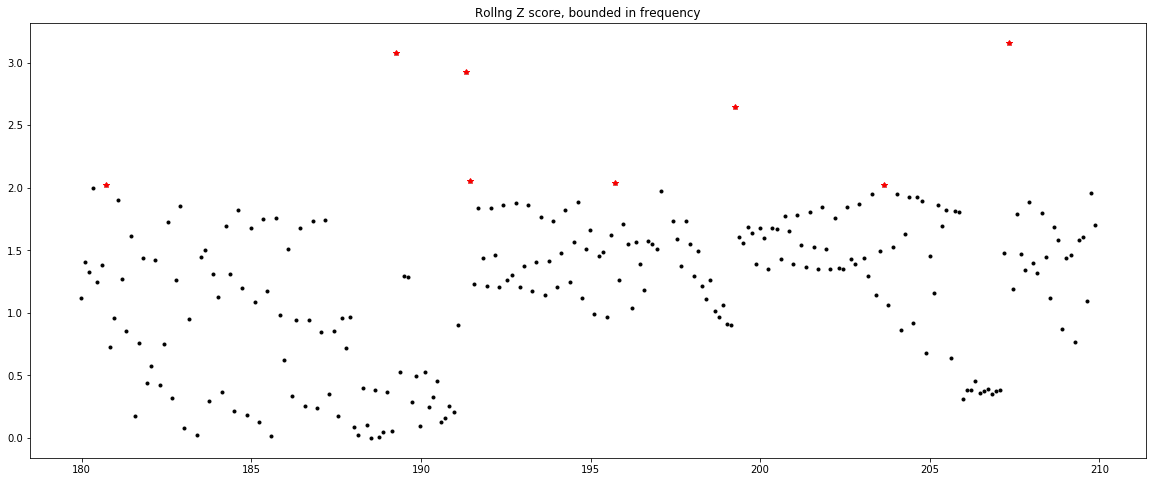

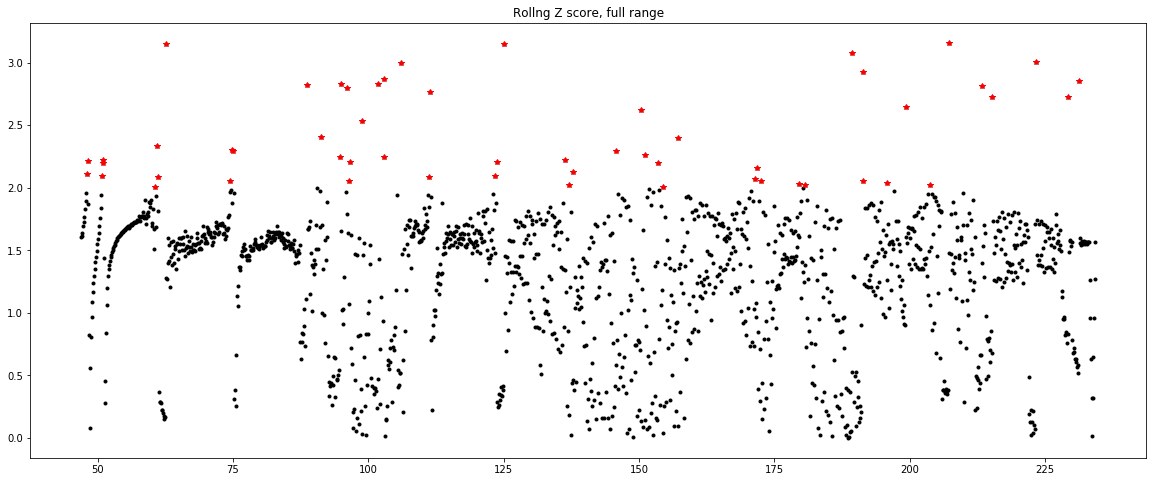

In [21]:

chan_min = (np.abs(uvd.freq_array[0]/1e6 - 180.)).argmin()
chan_max= (np.abs(uvd.freq_array[0]/1e6 - 210.)).argmin()
print('chan_min = '+str(chan_min)+', chan_max = '+str(chan_max))
#chan_min=50;chan_max=150;

plt.figure(figsize=(20,8))
plt.imshow(powers_per_time_XRFI[:,chan_min:chan_max], aspect='auto',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.title('Post-XRFI waterfall')

'''plt.figure(figsize=(20,8))
ratio_2D = np.log10(np.abs((powers_per_time_XRFI[1:,1:]/powers_per_time_XRFI[:-1,:-1])-1.)  ) 
plt.imshow(ratio_2D[:,chan_min:chan_max], aspect='auto',interpolation='nearest',cmap='gist_yarg',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi) ) 
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Post-XRFI Neighboring Channel Ratio')
'''

plt.figure(figsize=(20,8))
Nmed=7
int_P_dt = np.ma.sum(powers_per_time_XRFI,axis=0)/(np.size(powers_per_time[:,0])-np.sum(XRFI_mask,axis=0))
running_med_Pt= scipy.signal.medfilt(int_P_dt,Nmed)

#normalized_diff = np.abs(int_P_dt[Nmed/2 -1:] - running_med_Pt)/running_med_Pt
normalized_diff = np.abs(int_P_dt - running_med_Pt)/running_med_Pt

arr_z = scipy.stats.zscore(int_P_dt)
arr_rolling_z = rolling_z(int_P_dt,11)

print('Nmed = '+str(Nmed))
print('First Nmed values of running med: '+str(running_med_Pt[0:Nmed]))
print('Last Nmed values of running med: '+str(running_med_Pt[-Nmed:]))

plt.figure(figsize=(20,8))
plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6), int_P_dt[chan_min:chan_max],'r*')
plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6), running_med_Pt[chan_min:chan_max],'k*')
plt.title('Power per channel integrated over all time - Normalized for Number of Flags')


#plt.figure(figsize=(20,8))
#plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6), normalized_diff[chan_min:chan_max],'k.')
#plt.title('Normalized_difference')


#plt.figure(figsize=(20,8))
#plt.plot(np.array(uvd.freq_array[0][chan_min :chan_max]/1.e6), arr_z[chan_min:chan_max],'k.')
#plt.title('Z score')

plt.figure(figsize=(20,8))

idx_bad_range = np.argwhere(np.abs(arr_rolling_z[chan_min:chan_max])>2.0)
plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6), np.abs(arr_rolling_z[chan_min:chan_max]),'k.')
plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6)[idx_bad_range], np.abs(arr_rolling_z[chan_min:chan_max])[idx_bad_range],'r*')
plt.title('Rollng Z score, bounded in frequency')

idx_bad = np.argwhere(np.abs(arr_rolling_z)>2.0)
plt.figure(figsize=(20,8))
plt.plot(np.array(uvd.freq_array[0]/1.e6), np.abs(arr_rolling_z),'k.')
plt.plot(np.array(uvd.freq_array[0]/1.e6)[idx_bad], np.abs(arr_rolling_z)[idx_bad],'r*')
plt.title('Rollng Z score, full range')

# Compare the delay transforms of the pre/post rolling Z-score excision

(5.374556216184712, 9.842550552227568)

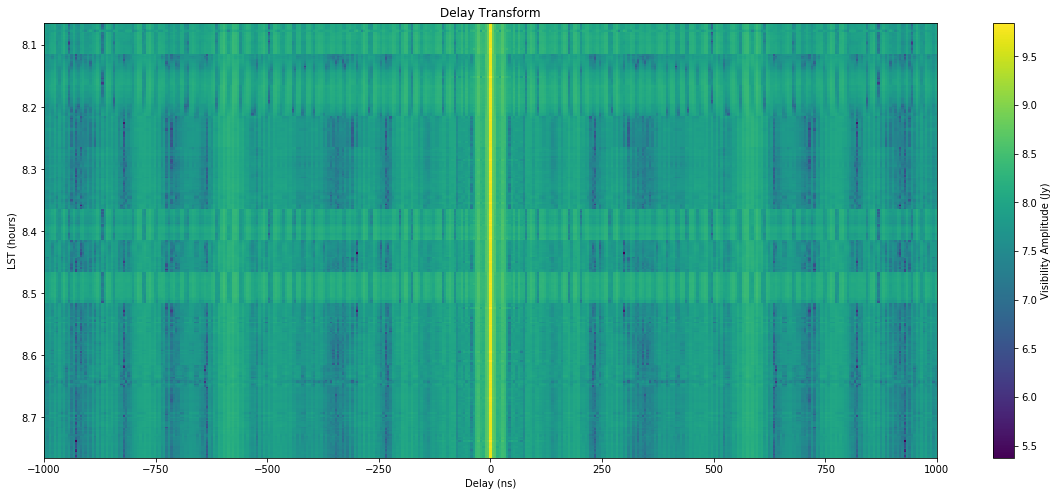

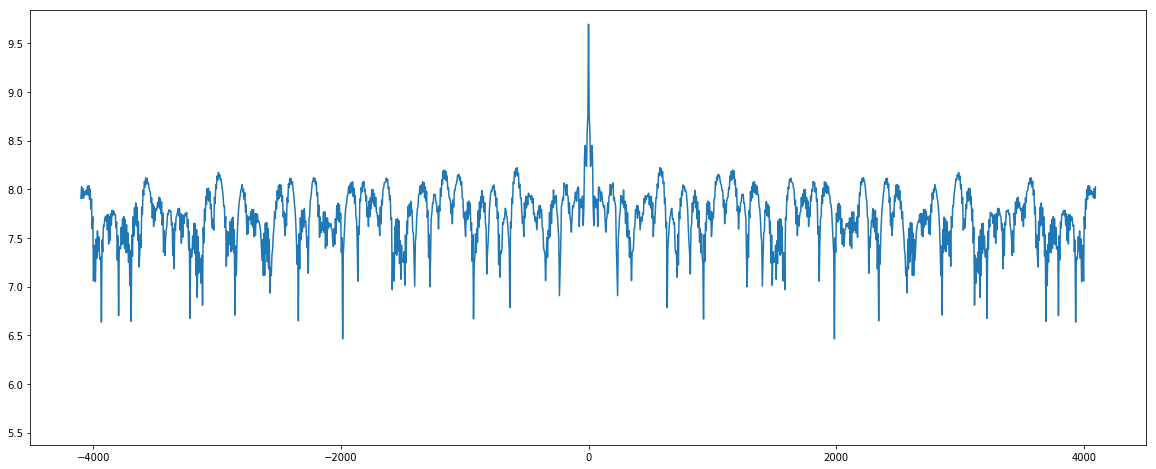

In [22]:
time_to_view=250#the row in vis_dt to plot separately.

vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1),axes=1) # Fourier-transform along frequency
amp_min = np.min(np.min(np.log10(np.abs(vis_dt)),axis=0))
amp_max = np.max(np.max(np.log10(np.abs(vis_dt)),axis=0))
# 2) Find the frequency width of a channel in GHz
#freq_width = # your answer here
freq_width = (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e9 # GHz

#3) Convert frequencies to delays. Numpy's fftfreq function takes two arguments: 
#   the number of frequencies, and the frequeny width you calculated above
#delays = # your answer here
delays = np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs,freq_width)) 

plt.figure(figsize=(20,8))
plt.imshow(np.log10(np.abs(vis_dt)), aspect='auto', vmin=amp_min,vmax=amp_max,
          extent=(np.min(delays),np.max(delays),
                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.xlim(-1000,1000) # zoom-in
plt.title('Delay Transform');

plt.figure(figsize=(20,8))
plt.plot(delays,np.log10(vis_dt[time_to_view,:]))
plt.ylim((amp_min,amp_max))

In [10]:
print(np.shape(uvd.flag_array))

(19404, 1, 1536, 4)


In [11]:
(19404./66.)/294. #Number of datasets = uvd.Ntimes * uvd.Nbls , where Nbls = # baselines = N(N-1)/2 ants. 

1.0

In [23]:
#print(str(uvd._key2inds(key)))
blt_data, conjugate_data, pol_ind = uvd._key2inds(key)
#print(str(np.shape(blt_data))) #for a given data set, these are the indices of ind1 that correspond to the time integrations of key 'key'

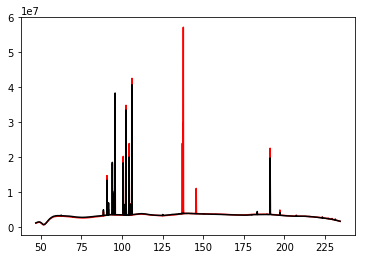

In [24]:
plt.plot(uvd.freq_array[0]/1e6 , np.abs(uvd.data_array[846,0,:,0]),'r') # confirmation of sensibility, orbcomm
plt.plot(uvd.freq_array[0]/1e6 , np.abs(uvd.data_array[19326,0,:,0]),'k') # confirmation of sensibility, no orbcomm

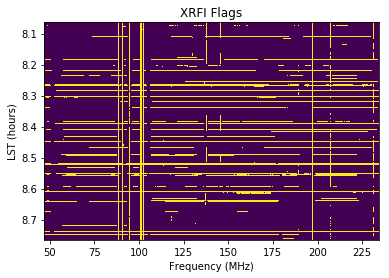

In [25]:
#get the XRFI flags only

plt.figure()
plt.imshow(XRFI_mask, aspect='auto',
          extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,
                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('XRFI Flags');

divide by zero encountered in log10


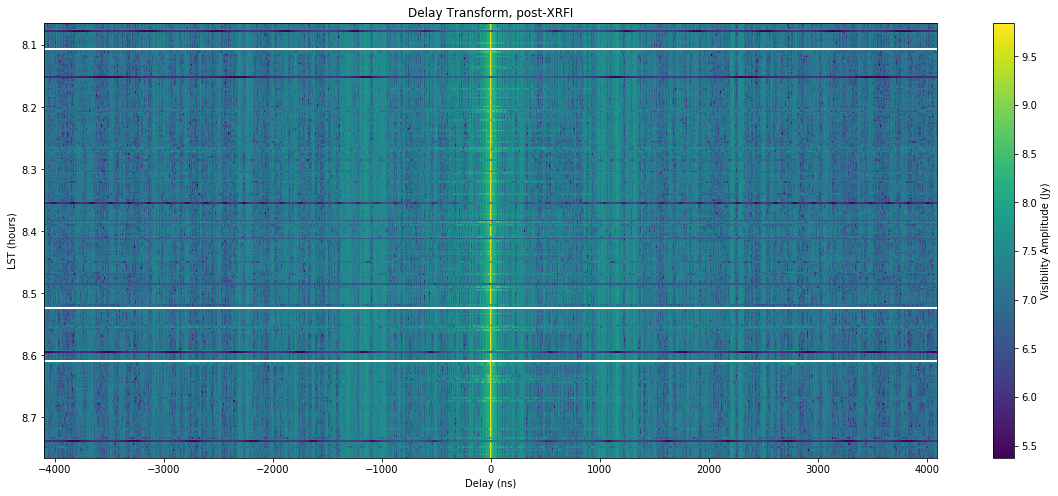

In [34]:

vis_XRFI = uvd.get_data(key)*~XRFI_mask

vis_dt_XRFI= np.fft.fftshift(np.fft.fft(vis_XRFI,axis=1),axes=1) # Fourier-transform along frequency
freq_width = (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs,freq_width)) # convert frequencies to delays

plt.figure(figsize=(20,8))
plt.imshow(np.log10(np.abs(vis_dt_XRFI)), aspect='auto',vmin=amp_min,vmax=amp_max,
          extent=(np.min(delays),np.max(delays),
                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
#plt.xlim(-1000,1000)
plt.title('Delay Transform, post-XRFI');



In [27]:
# now add the flags from rolling z-score
mask_Zscore = np.zeros((uvd.Ntimes,uvd.Nfreqs), dtype=bool)
mask_Zscore[:,idx_bad] = True
print('Number of channels blacklisted by rolling Z-score: '+str(np.sum(mask_Zscore[0,:])))

#plt.figure()
#plt.imshow(mask_Zscore, aspect='auto',
#          extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,
#                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
#plt.xlabel('Frequency (MHz)')
#plt.ylabel('LST (hours)')
#plt.title('Z-Score Flags');


#Merge the two masks:
mask_Z_and_XRFI = np.logical_or(mask_Zscore, XRFI_mask)
#plt.figure()
#plt.imshow(mask_Z_and_XRFI, aspect='auto',
#          extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,
#                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
#plt.xlabel('Frequency (MHz)')
#plt.ylabel('LST (hours)')
#plt.title('All Flags (Both XRFI and Z-Score)');


Number of channels blacklisted by rolling Z-score: 55


divide by zero encountered in log10


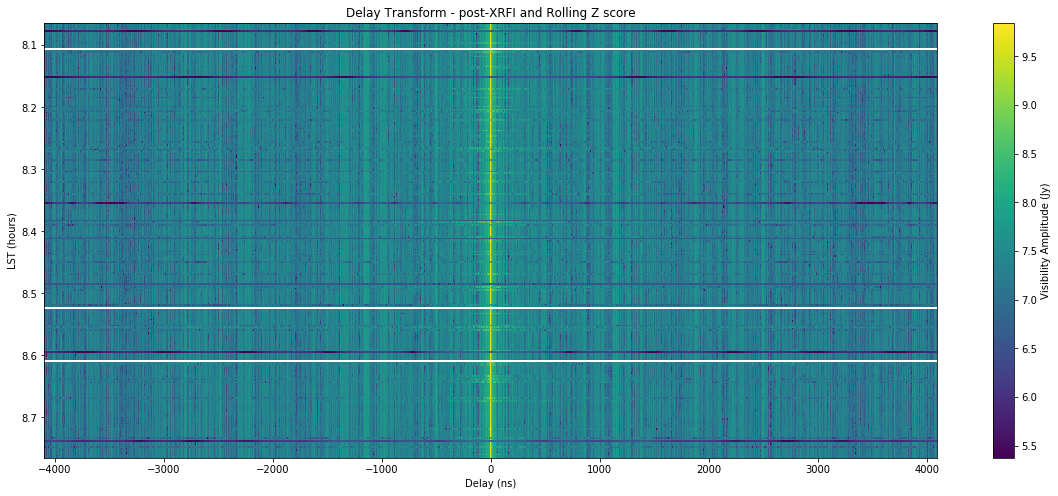

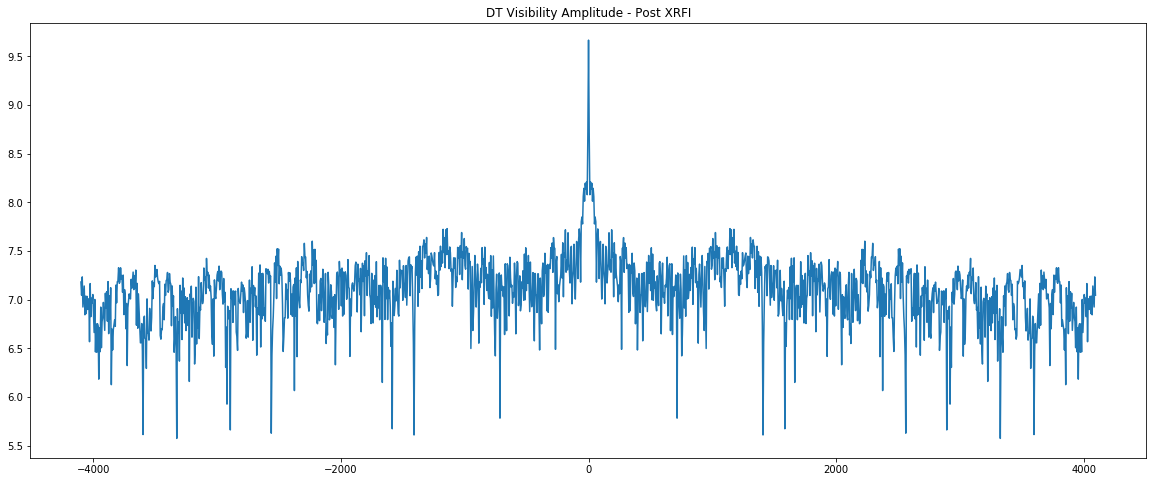

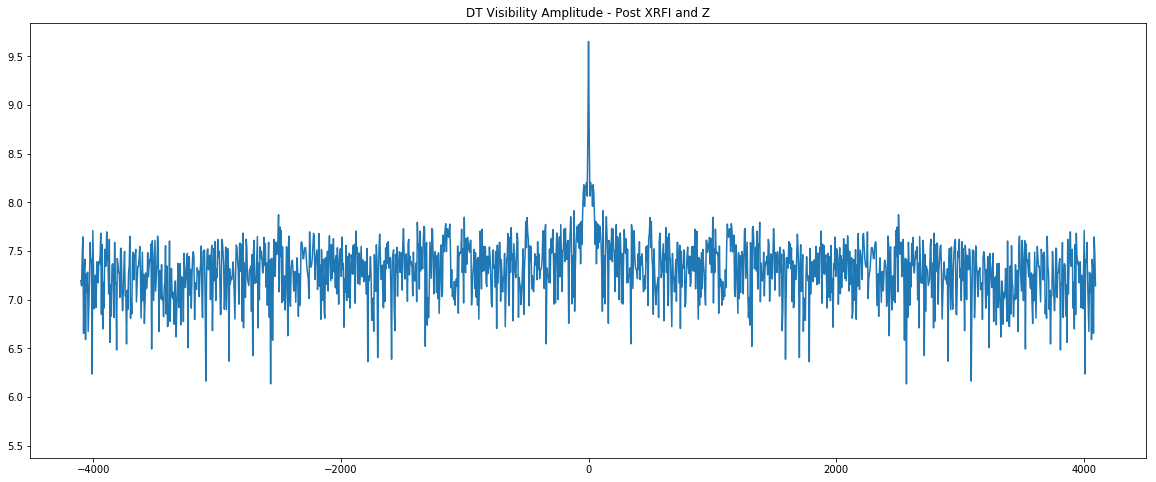

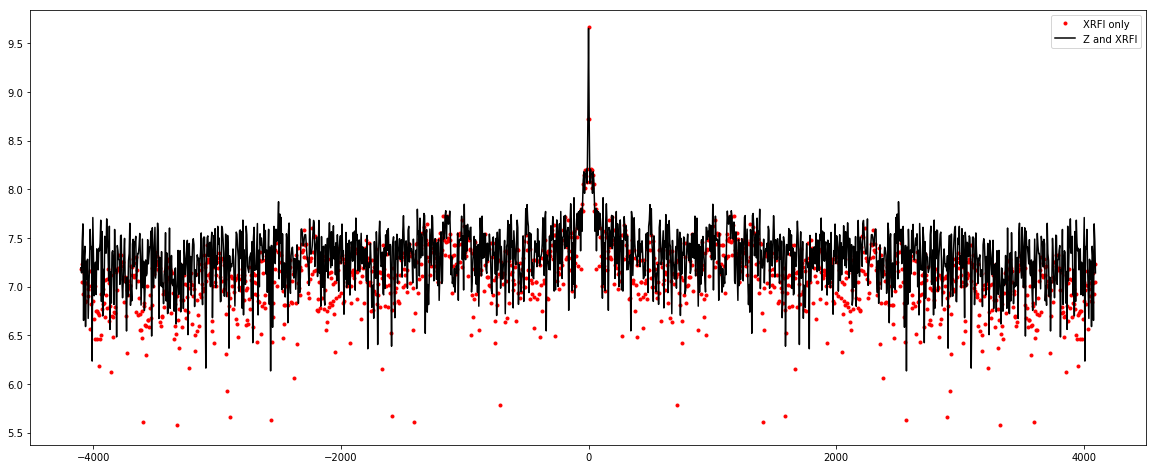

In [35]:
vis_Z_and_XRFI = uvd.get_data(key)*~mask_Z_and_XRFI

vis_dt_Z_and_XRFI= np.fft.fftshift(np.fft.fft(vis_Z_and_XRFI,axis=1),axes=1) # Fourier-transform along frequency
freq_width = (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs,freq_width)) # convert frequencies to delays

plt.figure(figsize=(20,8))
plt.imshow(np.log10(np.abs(vis_dt_Z_and_XRFI)), aspect='auto', vmin=amp_min,vmax=amp_max,
          extent=(np.min(delays),np.max(delays),
                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
#plt.xlim(-1000,1000)
plt.title('Delay Transform - post-XRFI and Rolling Z score');

plt.figure(figsize=(20,8))
plt.plot(delays,np.log10(vis_dt_XRFI[time_to_view,:]))
plt.ylim((amp_min,amp_max))
plt.title('DT Visibility Amplitude - Post XRFI')

plt.figure(figsize=(20,8))
plt.plot(delays,np.log10(vis_dt_Z_and_XRFI[time_to_view,:]))
plt.ylim((amp_min,amp_max))
plt.title('DT Visibility Amplitude - Post XRFI and Z')

plt.figure(figsize=(20,8))
plt.plot(delays,np.log10(vis_dt_XRFI[time_to_view,:]),'r.',label='XRFI only')
plt.plot(delays,np.log10(vis_dt_Z_and_XRFI[time_to_view,:]),'k',label='Z and XRFI')
plt.ylim((amp_min,amp_max))
plt.legend()

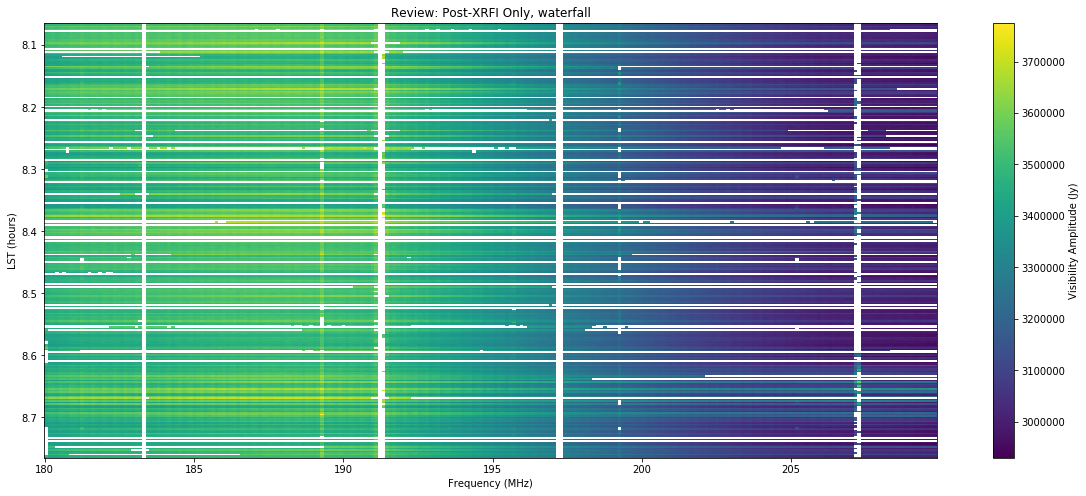

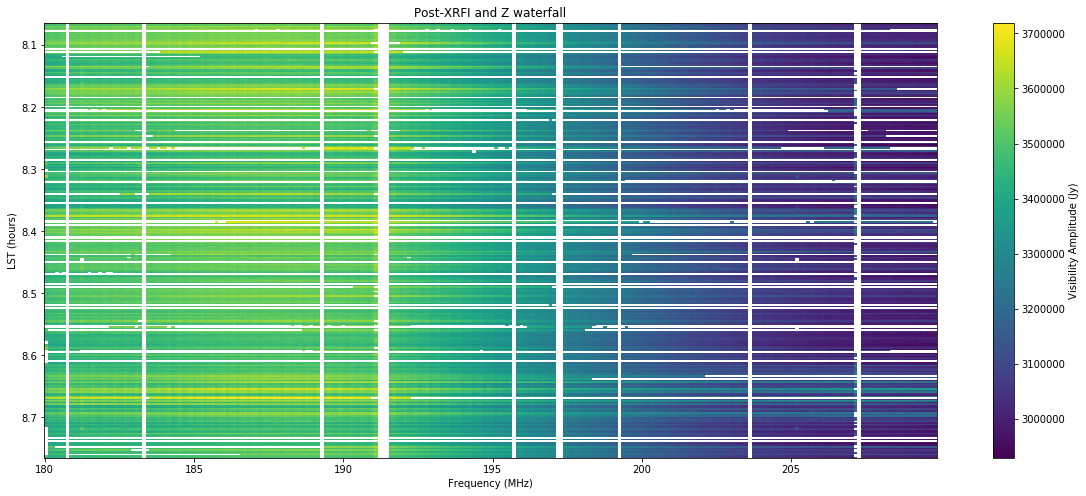

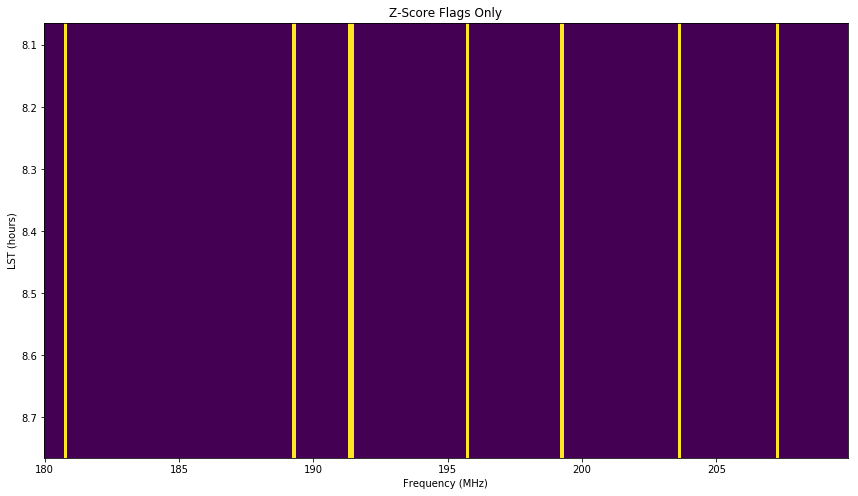

In [30]:
plt.figure(figsize=(20,8))
plt.imshow(powers_per_time_XRFI[:,chan_min:chan_max], aspect='auto',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.title('Review: Post-XRFI Only, waterfall')

plt.figure(figsize=(20,8))
powers_per_time_X_and_Z= np.ma.masked_array(np.abs(vis_Z_and_XRFI),mask=mask_Z_and_XRFI)
plt.imshow(powers_per_time_X_and_Z[:,chan_min:chan_max], aspect='auto',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.title('Post-XRFI and Z waterfall')
mask_Z_and_XRFI = np.logical_or(mask_Zscore, XRFI_mask)

plt.figure(figsize=(14.4,8))
plt.imshow(mask_Zscore[:,chan_min:chan_max], aspect='auto',
          extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,
                  np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Z-Score Flags Only');